In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys


%matplotlib inline

In [ ]:
df = pd.read_csv('loans_20200317_TTM.csv', parse_dates = True)
df['Days in original_closing_date'] = pd.to_datetime(df['Days in original_closing_date'])
df.rename({'Days in original_closing_date': 'closing_date'}, inplace = True, axis = 1)
df.set_index('closing_date', inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1899 entries, 2019-04-19 to 2019-12-27
Data columns (total 8 columns):
loan_id          1899 non-null object
county           1899 non-null object
state            1899 non-null object
market_area      1899 non-null object
loan_category    1899 non-null object
amount_closed    1899 non-null float64
validation       1899 non-null int64
litp_proxy       1899 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 89.0+ KB


In [ ]:
ppc = df[(df['validation'] == 1) & ((df['loan_category'] == 'Loan') | (df['loan_category'] == 'Leveraged Loan'))].copy()

## Resampling our data

Once the data is filtered we are resampling the data such data we could seasonally decompose and forecast our data

In [6]:
ppc = ppc.resample('MS').sum()
ppc.drop(columns = ['validation'], axis = 1, inplace = True)


In [7]:
ppc

amount_closed
closing_date               
1990-03-01        200000.00
1990-04-01         32000.00
1990-05-01             0.00
1990-06-01        157438.00
1990-07-01             0.00
1990-08-01             0.00
1990-09-01         80000.00
1990-10-01             0.00
1990-11-01        259000.00
1990-12-01             0.00
1991-01-01        200000.00
1991-02-01             0.00
1991-03-01        235000.00
1991-04-01             0.00
1991-05-01        203000.00
1991-06-01        250000.00
1991-07-01         34917.48
1991-08-01        420000.00
1991-09-01             0.00
1991-10-01        260000.00
1991-11-01        462500.00
1991-12-01             0.00
1992-01-01        812000.00
1992-02-01             0.00
1992-03-01        368724.00
1992-04-01             0.00
1992-05-01             0.00
1992-06-01             0.00
1992-07-01             0.00
1992-08-01             0.00
...                     ...
2017-09-01       4886832.00
2017-10-01       8338750.00
2017-11-01       5712240.00
2017-12-01       9624042.00
2018-01-01       1750000.00
2018-02-01        825000.00
2018-03-01       3402594.00
2018-04-01       1995000.00
2018-05-01      10210752.71
2018-06-01       7567386.00
2018-07-01       4480500.00
2018-08-01       4905850.00
2018-09-01      13208084.00
2018-10-01       3703250.00
2018-11-01       8415000.00
2018-12-01      13609194.71
2019-01-01       3266000.00
2019-02-01       1029774.00
2019-03-01       1500000.00
2019-04-01       8135439.00
2019-05-01       2934932.00
2019-06-01      13140816.00
2019-07-01       8630047.00
2019-08-01       4620000.00
2019-09-01       6212741.00
2019-10-01       5486666.00
2019-11-01       6328635.00
2019-12-01      12990899.00
2020-01-01      10496914.00
2020-02-01       1781430.00

[360 rows x 1 columns]

''

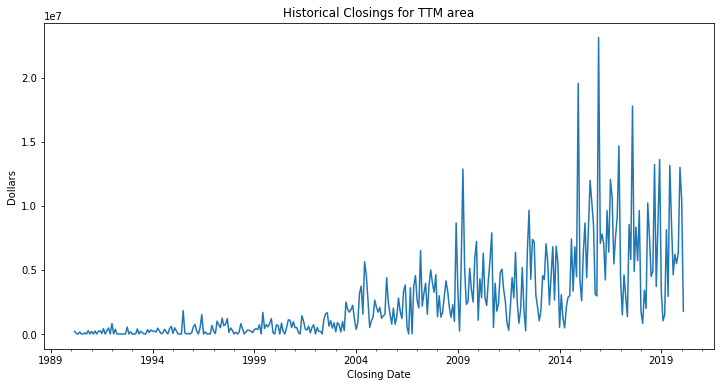

In [8]:
title  = 'Historical Closings for TTM area'
ylabel = 'Dollars'
xlabel = 'Closing Date'

ax = ppc['amount_closed'].plot(figsize = (12,6), title = title)
ax.set(xlabel = xlabel, ylabel = ylabel)
;

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

''

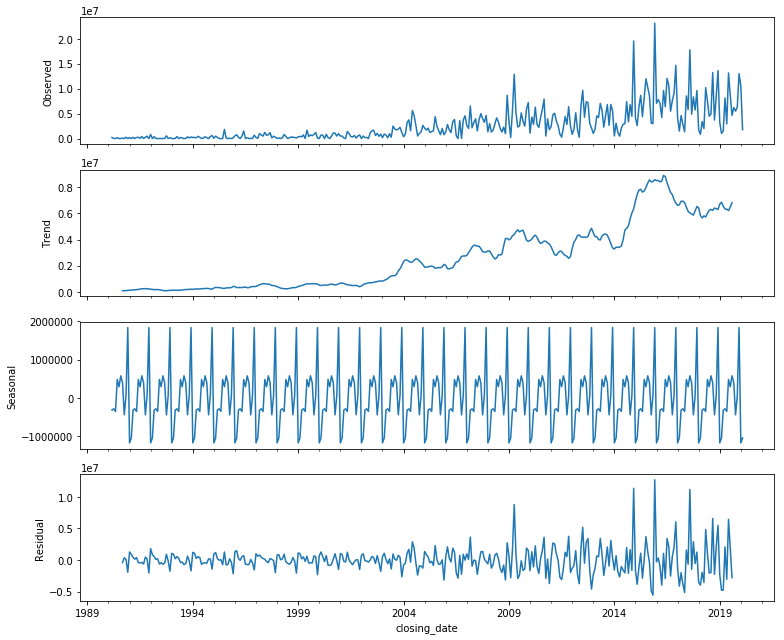

In [10]:
rcParams['figure.figsize'] = 11, 9
result = seasonal_decompose(ppc['amount_closed'], model = 'additive')
fig = result.plot()
;

In [11]:
fig.savefig('seasonal_ttm.png')

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [13]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    #prepare training dataset
    train_size = int(len(X) - 36)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    #make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate our of sample error
    error = mean_squared_error(test, predictions)
    return error

#evaluate combinations of p,d,q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [14]:
# import warnings

# series = ppc.copy()

# # evaluate parameters
# p_values = [0, 1, 2, 4, 6, 8, 10, 12]
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=32968972459791.250
ARIMA(0, 0, 1) MSE=28786616397901.004
ARIMA(0, 0, 2) MSE=26855028095818.418
ARIMA(0, 1, 0) MSE=34435237079610.723
ARIMA(0, 1, 1) MSE=19201556265478.109
ARIMA(0, 1, 2) MSE=19128527183581.605
ARIMA(0, 2, 0) MSE=99596072248510.469
ARIMA(1, 0, 0) MSE=25869001532312.328
ARIMA(1, 0, 2) MSE=19260772821575.574
ARIMA(1, 1, 0) MSE=26710147675996.473
ARIMA(1, 1, 1) MSE=19380730617766.812
ARIMA(1, 1, 2) MSE=19672138556576.379
ARIMA(1, 2, 0) MSE=57343283171204.398
ARIMA(2, 0, 0) MSE=23662175203811.973
ARIMA(2, 0, 1) MSE=19252016996961.457
ARIMA(2, 1, 0) MSE=25405938777968.055
ARIMA(2, 1, 1) MSE=20287298870176.496
ARIMA(2, 1, 2) MSE=20384142717595.359
ARIMA(2, 2, 0) MSE=45712468170621.133
ARIMA(4, 0, 0) MSE=23554775656718.133
ARIMA(4, 0, 1) MSE=20651231692743.457
ARIMA(4, 1, 0) MSE=25530555582850.773
ARIMA(4, 1, 1) MSE=20666080420529.082
ARIMA(4, 2, 0) MSE=38865324535849.945
ARIMA(6, 0, 0) MSE=23501298204924.020
ARIMA(6, 0, 1) MSE=20457584884417.215
ARIMA(6, 1, 

1. ARIMA(0, 0, 0) MSE=32968972459791.250
1. ARIMA(0, 0, 1) MSE=28786616397901.004
1. ARIMA(0, 0, 2) MSE=26855028095818.418
1. ARIMA(0, 1, 0) MSE=34435237079610.723
1. ARIMA(0, 1, 1) MSE=19201556265478.109
1. ARIMA(0, 1, 2) MSE=19128527183581.605
1. ARIMA(0, 2, 0) MSE=99596072248510.469
1. ARIMA(1, 0, 0) MSE=25869001532312.328
1. ARIMA(1, 0, 2) MSE=19260772821575.574
1. ARIMA(1, 1, 0) MSE=26710147675996.473
1. ARIMA(1, 1, 1) MSE=19380730617766.812
1. ARIMA(1, 1, 2) MSE=19672138556576.379
1. ARIMA(1, 2, 0) MSE=57343283171204.398
1. ARIMA(2, 0, 0) MSE=23662175203811.973
1. ARIMA(2, 0, 1) MSE=19252016996961.457
1. ARIMA(2, 1, 0) MSE=25405938777968.055
1. ARIMA(2, 1, 1) MSE=20287298870176.496
1. ARIMA(2, 1, 2) MSE=20384142717595.359
1. ARIMA(2, 2, 0) MSE=45712468170621.133
1. ARIMA(4, 0, 0) MSE=23554775656718.133
1. ARIMA(4, 0, 1) MSE=20651231692743.457
1. ARIMA(4, 1, 0) MSE=25530555582850.773
1. ARIMA(4, 1, 1) MSE=20666080420529.082
1. ARIMA(4, 2, 0) MSE=38865324535849.945
1. ARIMA(6, 0, 0) MSE=23501298204924.020
1. ARIMA(6, 0, 1) MSE=20457584884417.215
1. ARIMA(6, 1, 0) MSE=23338399818371.113
1. ARIMA(6, 1, 1) MSE=21123372846697.344
1. ARIMA(6, 1, 2) MSE=21166089875550.043
1. ARIMA(6, 2, 0) MSE=33511444663712.070
1. ARIMA(6, 2, 1) MSE=23597658292757.566
1. ARIMA(8, 0, 0) MSE=23762449855857.098
1. ARIMA(8, 0, 1) MSE=21723296898692.984
1. ARIMA(8, 0, 2) MSE=23095354807290.285
1. ARIMA(8, 1, 0) MSE=23347349492744.453
1. ARIMA(8, 1, 1) MSE=21870694038331.770
1. ARIMA(8, 1, 2) MSE=22473916132512.746
1. ARIMA(8, 2, 0) MSE=31345225601103.305
1. ARIMA(10, 0, 0) MSE=23356457183690.609
1. ARIMA(10, 0, 1) MSE=22428399133603.980
1. ARIMA(10, 1, 1) MSE=20915436452004.328
1. ARIMA(10, 2, 0) MSE=32094671254869.332
1. ARIMA(10, 2, 1) MSE=23503992642304.289
1. ARIMA(12, 0, 0) MSE=18974418591976.051
1. ARIMA(12, 0, 1) MSE=19603901319954.492
1. ARIMA(12, 0, 2) MSE=19087362338730.160
1. ARIMA(12, 1, 0) MSE=19636126226969.422
1. ARIMA(12, 1, 1) MSE=19951655091682.668
1. ARIMA(12, 1, 2) MSE=19604504525524.137
1. ARIMA(12, 2, 1) MSE=19958465008425.875
1. Best ARIMA(12, 0, 0) MSE=18974418591976.051

In [22]:
lst = [
        ['ARIMA(0, 0, 0)', 32968972459791.250],
        ['ARIMA(0, 0, 1)', 28786616397901.004],
        ['ARIMA(0, 0, 2)', 26855028095818.418],
        ['ARIMA(0, 1, 0)', 34435237079610.723],
        ['ARIMA(0, 1, 1)', 19201556265478.109],
        ['ARIMA(0, 1, 2)', 19128527183581.605],
        ['ARIMA(0, 2, 0)', 99596072248510.469],
        ['ARIMA(1, 0, 0)', 25869001532312.328],
        ['ARIMA(1, 0, 2)', 19260772821575.574],
        ['ARIMA(1, 1, 0)', 26710147675996.473],
        ['ARIMA(1, 1, 1)', 19380730617766.812],
        ['ARIMA(1, 1, 2)', 19672138556576.379],
        ['ARIMA(1, 2, 0)', 57343283171204.398],
        ['ARIMA(2, 0, 0)', 23662175203811.973],
        ['ARIMA(2, 0, 1)', 19252016996961.457],
        ['ARIMA(2, 1, 0)', 25405938777968.055],
        ['ARIMA(2, 1, 1)', 20287298870176.496],
        ['ARIMA(2, 1, 2)', 20384142717595.359],
        ['ARIMA(2, 2, 0)', 45712468170621.133],
        ['ARIMA(4, 0, 0)', 23554775656718.133],
        ['ARIMA(4, 0, 1)', 20651231692743.457],
        ['ARIMA(4, 1, 0)', 25530555582850.773],
        ['ARIMA(4, 1, 1)', 20666080420529.082],
        ['ARIMA(4, 2, 0)', 38865324535849.945],
        ['ARIMA(6, 0, 0)', 23501298204924.020],
        ['ARIMA(6, 0, 1)', 20457584884417.215],
        ['ARIMA(6, 1, 0)', 23338399818371.113],
        ['ARIMA(6, 1, 1)', 21123372846697.344],
        ['ARIMA(6, 1, 2)', 21166089875550.043],
        ['ARIMA(6, 2, 0)', 33511444663712.070],
        ['ARIMA(6, 2, 1)', 23597658292757.566],
        ['ARIMA(8, 0, 0)', 23762449855857.098],
        ['ARIMA(8, 0, 1)', 21723296898692.984],
        ['ARIMA(8, 0, 2)', 23095354807290.285],
        ['ARIMA(8, 1, 0)', 23347349492744.453],
        ['ARIMA(8, 1, 1)', 21870694038331.770],
        ['ARIMA(8, 1, 2)', 22473916132512.746],
        ['ARIMA(8, 2, 0)', 31345225601103.305],
        ['ARIMA(10, 0, 0)', 23356457183690.609],
        ['ARIMA(10, 0, 1)', 22428399133603.980],
        ['ARIMA(10, 1, 0)', 22994519450846.434],
        ['ARIMA(10, 1, 1)', 20915436452004.328],
        ['ARIMA(10, 2, 0)', 32094671254869.332],
        ['ARIMA(10, 2, 1)', 23503992642304.289],
        ['ARIMA(12, 0, 0)', 18974418591976.051],
        ['ARIMA(12, 0, 1)', 19603901319954.492],
        ['ARIMA(12, 0, 2)', 19087362338730.160],
        ['ARIMA(12, 1, 0)', 19636126226969.422],
        ['ARIMA(12, 1, 1)', 19951655091682.668],
        ['ARIMA(12, 1, 2)', 19604504525524.137],
        ['ARIMA(12, 2, 1)', 19958465008425.875]
]


arima_values = pd.DataFrame(lst, columns = ['ARIMA', 'MSE'])
arima_values.sort_values(by= 'MSE', ascending= False, inplace = True)
arima_values['MSE'] = ['{:,.2f}'.format(i) for i in arima_values['MSE']]
arima_values

ARIMA                    MSE
6    ARIMA(0, 2, 0)  99,596,072,248,510.47
12   ARIMA(1, 2, 0)  57,343,283,171,204.40
18   ARIMA(2, 2, 0)  45,712,468,170,621.13
23   ARIMA(4, 2, 0)  38,865,324,535,849.95
3    ARIMA(0, 1, 0)  34,435,237,079,610.72
29   ARIMA(6, 2, 0)  33,511,444,663,712.07
0    ARIMA(0, 0, 0)  32,968,972,459,791.25
42  ARIMA(10, 2, 0)  32,094,671,254,869.33
37   ARIMA(8, 2, 0)  31,345,225,601,103.30
1    ARIMA(0, 0, 1)  28,786,616,397,901.00
2    ARIMA(0, 0, 2)  26,855,028,095,818.42
9    ARIMA(1, 1, 0)  26,710,147,675,996.47
7    ARIMA(1, 0, 0)  25,869,001,532,312.33
21   ARIMA(4, 1, 0)  25,530,555,582,850.77
15   ARIMA(2, 1, 0)  25,405,938,777,968.05
31   ARIMA(8, 0, 0)  23,762,449,855,857.10
13   ARIMA(2, 0, 0)  23,662,175,203,811.97
30   ARIMA(6, 2, 1)  23,597,658,292,757.57
19   ARIMA(4, 0, 0)  23,554,775,656,718.13
43  ARIMA(10, 2, 1)  23,503,992,642,304.29
24   ARIMA(6, 0, 0)  23,501,298,204,924.02
38  ARIMA(10, 0, 0)  23,356,457,183,690.61
34   ARIMA(8, 1, 0)  23,347,349,492,744.45
26   ARIMA(6, 1, 0)  23,338,399,818,371.11
33   ARIMA(8, 0, 2)  23,095,354,807,290.29
40  ARIMA(10, 1, 0)  22,994,519,450,846.43
36   ARIMA(8, 1, 2)  22,473,916,132,512.75
39  ARIMA(10, 0, 1)  22,428,399,133,603.98
35   ARIMA(8, 1, 1)  21,870,694,038,331.77
32   ARIMA(8, 0, 1)  21,723,296,898,692.98
28   ARIMA(6, 1, 2)  21,166,089,875,550.04
27   ARIMA(6, 1, 1)  21,123,372,846,697.34
41  ARIMA(10, 1, 1)  20,915,436,452,004.33
22   ARIMA(4, 1, 1)  20,666,080,420,529.08
20   ARIMA(4, 0, 1)  20,651,231,692,743.46
25   ARIMA(6, 0, 1)  20,457,584,884,417.21
17   ARIMA(2, 1, 2)  20,384,142,717,595.36
16   ARIMA(2, 1, 1)  20,287,298,870,176.50
50  ARIMA(12, 2, 1)  19,958,465,008,425.88
48  ARIMA(12, 1, 1)  19,951,655,091,682.67
11   ARIMA(1, 1, 2)  19,672,138,556,576.38
47  ARIMA(12, 1, 0)  19,636,126,226,969.42
49  ARIMA(12, 1, 2)  19,604,504,525,524.14
45  ARIMA(12, 0, 1)  19,603,901,319,954.49
10   ARIMA(1, 1, 1)  19,380,730,617,766.81
8    ARIMA(1, 0, 2)  19,260,772,821,575.57
14   ARIMA(2, 0, 1)  19,252,016,996,961.46
4    ARIMA(0, 1, 1)  19,201,556,265,478.11
5    ARIMA(0, 1, 2)  19,128,527,183,581.61
46  ARIMA(12, 0, 2)  19,087,362,338,730.16
44  ARIMA(12, 0, 0)  18,974,418,591,976.05

In [23]:
#set train and test for three years
train_size = int(len(ppc) - 36) 
train = ppc[:train_size]
test  = ppc[train_size:]

## ARIMA modelling and plotting

In [25]:
model = ARIMA(train['amount_closed'], order = (12,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          amount_closed   No. Observations:                  324
Model:                    ARMA(12, 0)   Log Likelihood               -5162.743
Method:                       css-mle   S.D. of innovations        2002335.782
Date:                Thu, 19 Mar 2020   AIC                          10353.486
Time:                        05:39:27   BIC                          10406.416
Sample:                    03-01-1990   HQIC                         10374.613
                         - 02-01-2017                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.218e+06    2.7e+06      0.821      0.412   -3.08e+06    7.51e+06
ar.L1.amount_closed      0.1466      0.053      2.741      0.006       0.042       0.251
ar.L2.amount_closed     -0.0335      0.054     -0.618      0.537      -0.140       0.073
ar.L3.amount_closed      0.1197      0.055      2.165      0.031       0.011       0.228
ar.L4.amount_closed      0.0989      0.055      1.784      0.075      -0.010       0.208
ar.L5.amount_closed      0.0763      0.055      1.383      0.168      -0.032       0.185
ar.L6.amount_closed      0.0373      0.055      0.682      0.496      -0.070       0.144
ar.L7.amount_closed      0.1088      0.055      1.978      0.049       0.001       0.217
ar.L8.amount_closed      0.1202      0.056      2.157      0.032       0.011       0.229
ar.L9.amount_closed     -0.0094      0.056     -0.168      0.866      -0.119       0.100
ar.L10.amount_closed     0.0189      0.055      0.341      0.733      -0.090       0.128
ar.L11.amount_closed    -0.0259      0.056     -0.463      0.644      -0.136       0.084
ar.L12.amount_closed     0.3132      0.055      5.678      0.000       0.205       0.421
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1078           -0.0000j            1.1078           -0.5000
AR.2            -0.9388           -0.5840j            1.1056           -0.4114
AR.3            -0.9388           +0.5840j            1.1056            0.4114
AR.4            -0.5412           -0.9846j            1.1235           -0.3300
AR.5            -0.5412           +0.9846j            1.1235            0.3300
AR.6            -0.0022           -1.0713j            1.0713           -0.2503
AR.7            -0.0022           +1.0713j            1.0713            0.2503
AR.8             0.5781           -0.9433j            1.1064           -0.1625
AR.9             0.5781           +0.9433j            1.1064            0.1625
AR.10            1.0042           -0.0000j            1.0042           -0.0000
AR.11            0.9972           -0.5742j            1.1507           -0.0831
AR.12            0.9972           +0.5742j            1.1507            0.0831
------------------------------------------------------------------------------
"""

In [26]:
# obtain predicted values
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA(12,0,0) Predictions')
ppc['ARIMA'] = predictions
predictions

2017-03-01    8.410891e+06
2017-04-01    7.132701e+06
2017-05-01    7.336464e+06
2017-06-01    6.659231e+06
2017-07-01    8.971365e+06
2017-08-01    8.906595e+06
2017-09-01    5.667981e+06
2017-10-01    6.619361e+06
2017-11-01    7.909268e+06
2017-12-01    9.584830e+06
2018-01-01    6.547763e+06
2018-02-01    5.159400e+06
2018-03-01    7.819627e+06
2018-04-01    7.392256e+06
2018-05-01    6.789720e+06
2018-06-01    6.739136e+06
2018-07-01    7.737790e+06
2018-08-01    7.863366e+06
2018-09-01    6.302708e+06
2018-10-01    6.569568e+06
2018-11-01    7.338017e+06
2018-12-01    7.777084e+06
2019-01-01    6.801149e+06
2019-02-01    6.243582e+06
2019-03-01    7.252389e+06
2019-04-01    7.130996e+06
2019-05-01    6.650003e+06
2019-06-01    6.681961e+06
2019-07-01    7.126760e+06
2019-08-01    7.201770e+06
2019-09-01    6.519140e+06
2019-10-01    6.555561e+06
2019-11-01    6.945433e+06
2019-12-01    7.038126e+06
2020-01-01    6.672423e+06
2020-02-01    6.470313e+06
Freq: MS, Name: ARIMA(12,0,0

''

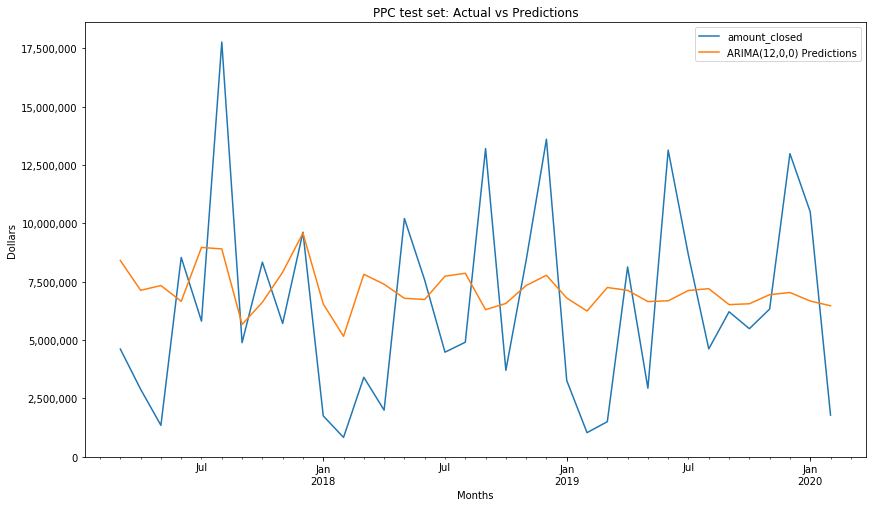

In [27]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# plot predictions against known values
title = 'PPC test set: Actual vs Predictions'
ylabel = 'Dollars'
xlabel = 'Months'

ax = test['amount_closed'].plot(legend = True, figsize = (14,8), title = title)
predictions.plot(legend = True)
ax.set(ylabel = ylabel, xlabel = xlabel)
ax.yaxis.set_major_formatter(formatter)
;

## SARIMAX modelling and plotting

In [28]:
model = SARIMAX(train['amount_closed'], order = (12,0,0), seasonal_order= (3,1,1,15))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                       amount_closed   No. Observations:                  324
Model:             SARIMAX(12, 0, 0)x(3, 1, 1, 15)   Log Likelihood               -4955.481
Date:                             Thu, 19 Mar 2020   AIC                           9944.962
Time:                                     05:41:47   BIC                          10008.429
Sample:                                 03-01-1990   HQIC                          9970.336
                                      - 02-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1801      0.112      1.615      0.106      -0.039       0.399
ar.L2         -0.0225      0.091     -0.247      0.805      -0.201       0.156
ar.L3          0.0812      0.114      0.711      0.477      -0.143       0.305
ar.L4          0.1060      0.068      1.566      0.117      -0.027       0.239
ar.L5          0.0731      0.110      0.664      0.506      -0.143       0.289
ar.L6         -0.0068      0.095     -0.072      0.943      -0.192       0.179
ar.L7          0.1256      0.076      1.658      0.097      -0.023       0.274
ar.L8          0.1098      0.114      0.963      0.335      -0.114       0.333
ar.L9         -0.0550      0.094     -0.586      0.558      -0.239       0.129
ar.L10         0.0726      0.100      0.729      0.466      -0.123       0.268
ar.L11        -0.0172      0.098     -0.176      0.860      -0.208       0.174
ar.L12         0.3056      0.075      4.056      0.000       0.158       0.453
ar.S.L15      -0.3024      0.177     -1.712      0.087      -0.649       0.044
ar.S.L30      -0.1854      0.186     -0.994      0.320      -0.551       0.180
ar.S.L45      -0.1631      0.159     -1.025      0.305      -0.475       0.149
ma.S.L15      -0.7071      0.181     -3.915      0.000      -1.061      -0.353
sigma2      7.568e+12   1.44e-14   5.25e+26      0.000    7.57e+12    7.57e+12
===================================================================================
Ljung-Box (Q):                       56.10   Jarque-Bera (JB):              2989.24
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              63.36   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.41e+42. Standard errors may be unstable.
"""

In [29]:
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMAX(12,0,0) order(3,1,1,15)  Predictions')
ppc['SARIMAX'] = predictions
predictions

2017-03-01    7.934750e+06
2017-04-01    6.395247e+06
2017-05-01    7.312228e+06
2017-06-01    9.683075e+06
2017-07-01    9.798262e+06
2017-08-01    9.606984e+06
2017-09-01    7.022097e+06
2017-10-01    7.535586e+06
2017-11-01    6.921039e+06
2017-12-01    9.380553e+06
2018-01-01    7.539796e+06
2018-02-01    6.041926e+06
2018-03-01    8.448040e+06
2018-04-01    6.285208e+06
2018-05-01    7.889336e+06
2018-06-01    9.516005e+06
2018-07-01    7.382670e+06
2018-08-01    8.482385e+06
2018-09-01    9.845293e+06
2018-10-01    7.172186e+06
2018-11-01    8.627812e+06
2018-12-01    9.217881e+06
2019-01-01    7.999299e+06
2019-02-01    6.337389e+06
2019-03-01    7.196634e+06
2019-04-01    7.558095e+06
2019-05-01    7.930290e+06
2019-06-01    8.627857e+06
2019-07-01    6.283589e+06
2019-08-01    8.219074e+06
2019-09-01    9.307420e+06
2019-10-01    7.349818e+06
2019-11-01    7.930533e+06
2019-12-01    1.276397e+07
2020-01-01    7.866883e+06
2020-02-01    8.012093e+06
Freq: MS, Name: SARIMAX(12,0

''

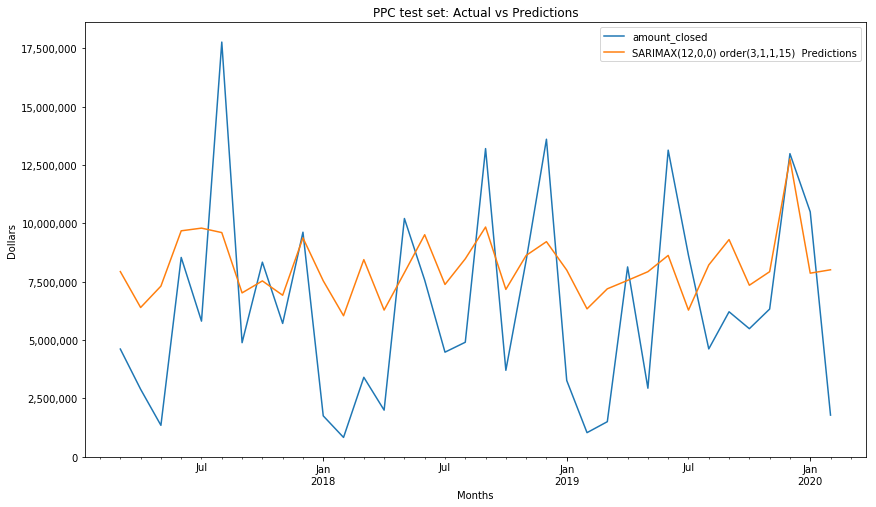

In [30]:
# plot predictions against known values
title = 'PPC test set: Actual vs Predictions'
ylabel = 'Dollars'
xlabel = 'Months'

ax = test['amount_closed'].plot(legend = True, figsize = (14,8), title = title)
predictions.plot(legend = True)
ax.set(ylabel = ylabel, xlabel = xlabel)
ax.yaxis.set_major_formatter(formatter)
;

## Exponential Weighted Average

In [31]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [32]:
span = 36
alpha = 2/(span+1)

ppc['EWMA'] = SimpleExpSmoothing(ppc['amount_closed']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
ppc['DESadd36'] = ExponentialSmoothing(ppc['amount_closed'], trend='add').fit().fittedvalues.shift(-1)
ppc.head()

amount_closed  ARIMA  SARIMAX           EWMA       DESadd36
closing_date                                                             
1990-03-01         200000.0    NaN      NaN  200000.000000  200000.000000
1990-04-01          32000.0    NaN      NaN  190918.918919  188421.546216
1990-05-01              0.0    NaN      NaN  180598.977356  175365.463615
1990-06-01         157438.0    NaN      NaN  179347.032634  173981.004708
1990-07-01              0.0    NaN      NaN  169652.598437  161833.944493

''

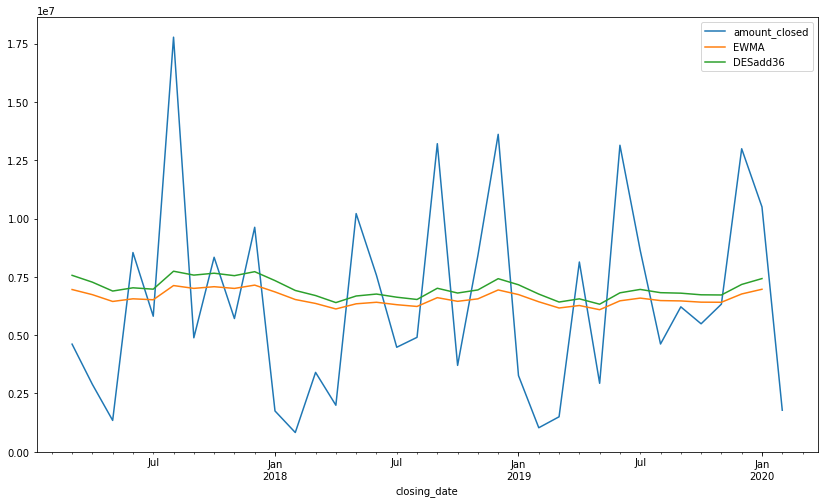

In [33]:
ppc[['amount_closed', 'EWMA', 'DESadd36']].iloc[train_size:].plot(figsize = (14,8))
;

## Retrain ARIMA, SARIMAX, EWMA, DESaad36 for 2020 - 2022 Forecast

In [34]:
ppc

amount_closed         ARIMA       SARIMAX          EWMA  \
closing_date                                                            
1990-03-01        200000.00           NaN           NaN  2.000000e+05   
1990-04-01         32000.00           NaN           NaN  1.909189e+05   
1990-05-01             0.00           NaN           NaN  1.805990e+05   
1990-06-01        157438.00           NaN           NaN  1.793470e+05   
1990-07-01             0.00           NaN           NaN  1.696526e+05   
1990-08-01             0.00           NaN           NaN  1.604822e+05   
1990-09-01         80000.00           NaN           NaN  1.561318e+05   
1990-10-01             0.00           NaN           NaN  1.476922e+05   
1990-11-01        259000.00           NaN           NaN  1.537089e+05   
1990-12-01             0.00           NaN           NaN  1.454003e+05   
1991-01-01        200000.00           NaN           NaN  1.483516e+05   
1991-02-01             0.00           NaN           NaN  1.403326e+05   
1991-03-01        235000.00           NaN           NaN  1.454498e+05   
1991-04-01             0.00           NaN           NaN  1.375876e+05   
1991-05-01        203000.00           NaN           NaN  1.411234e+05   
1991-06-01        250000.00           NaN           NaN  1.470086e+05   
1991-07-01         34917.48           NaN           NaN  1.409497e+05   
1991-08-01        420000.00           NaN           NaN  1.560335e+05   
1991-09-01             0.00           NaN           NaN  1.475992e+05   
1991-10-01        260000.00           NaN           NaN  1.536749e+05   
1991-11-01        462500.00           NaN           NaN  1.703682e+05   
1991-12-01             0.00           NaN           NaN  1.611591e+05   
1992-01-01        812000.00           NaN           NaN  1.963397e+05   
1992-02-01             0.00           NaN           NaN  1.857267e+05   
1992-03-01        368724.00           NaN           NaN  1.956185e+05   
1992-04-01             0.00           NaN           NaN  1.850445e+05   
1992-05-01             0.00           NaN           NaN  1.750421e+05   
1992-06-01             0.00           NaN           NaN  1.655804e+05   
1992-07-01             0.00           NaN           NaN  1.566301e+05   
1992-08-01             0.00           NaN           NaN  1.481636e+05   
...                     ...           ...           ...           ...   
2017-09-01       4886832.00  5.667981e+06  7.022097e+06  7.004733e+06   
2017-10-01       8338750.00  6.619361e+06  7.535586e+06  7.076842e+06   
2017-11-01       5712240.00  7.909268e+06  6.921039e+06  7.003079e+06   
2017-12-01       9624042.00  9.584830e+06  9.380553e+06  7.144753e+06   
2018-01-01       1750000.00  6.547763e+06  7.539796e+06  6.853145e+06   
2018-02-01        825000.00  5.159400e+06  6.041926e+06  6.527299e+06   
2018-03-01       3402594.00  7.819627e+06  8.448040e+06  6.358396e+06   
2018-04-01       1995000.00  7.392256e+06  6.285208e+06  6.122537e+06   
2018-05-01      10210752.71  6.789720e+06  7.889336e+06  6.343522e+06   
2018-06-01       7567386.00  6.739136e+06  9.516005e+06  6.409676e+06   
2018-07-01       4480500.00  7.737790e+06  7.382670e+06  6.305397e+06   
2018-08-01       4905850.00  7.863366e+06  8.482385e+06  6.229745e+06   
2018-09-01      13208084.00  6.302708e+06  9.845293e+06  6.606953e+06   
2018-10-01       3703250.00  6.569568e+06  7.172186e+06  6.449996e+06   
2018-11-01       8415000.00  7.338017e+06  8.627812e+06  6.556212e+06   
2018-12-01      13609194.71  7.777084e+06  9.217881e+06  6.937455e+06   
2019-01-01       3266000.00  6.801149e+06  7.999299e+06  6.738998e+06   
2019-02-01       1029774.00  6.243582e+06  6.337389e+06  6.430391e+06   
2019-03-01       1500000.00  7.252389e+06  7.196634e+06  6.163883e+06   
2019-04-01       8135439.00  7.130996e+06  7.558095e+06  6.270454e+06   
2019-05-01       2934932.00  6.650003e+06  7.930290e+06  6.090155e+06   
2019-06-01      13140816.00  6.681961e+06  8.627857e+06  6.471272e+06   

In [35]:
# ARIMA
model = ARIMA(ppc['amount_closed'], order = (12,0,0))
results = model.fit()
frcst_arima = results.predict(start = len(ppc), end = len(ppc) + 36).rename('ARIMA(12,0,0) Predictions')


In [36]:
ppc_frcst= pd.DataFrame(frcst_arima)
ppc_frcst['ARIMA(12,0,0) Predictions'] = [0 if i < 0 else i for i in ppc_frcst['ARIMA(12,0,0) Predictions']]
ppc_frcst

ARIMA(12,0,0) Predictions
2020-03-01               4.846581e+06
2020-04-01               7.085974e+06
2020-05-01               4.864943e+06
2020-06-01               8.405712e+06
2020-07-01               8.368261e+06
2020-08-01               6.372404e+06
2020-09-01               6.142631e+06
2020-10-01               6.108521e+06
2020-11-01               5.953107e+06
2020-12-01               8.538583e+06
2021-01-01               8.220542e+06
2021-02-01               4.980784e+06
2021-03-01               5.889010e+06
2021-04-01               6.692791e+06
2021-05-01               5.682138e+06
2021-06-01               6.807585e+06
2021-07-01               7.386653e+06
2021-08-01               6.546111e+06
2021-09-01               6.173729e+06
2021-10-01               6.225053e+06
2021-11-01               6.020306e+06
2021-12-01               6.920426e+06
2022-01-01               7.008080e+06
2022-02-01               5.875240e+06
2022-03-01               6.101360e+06
2022-04-01               6.398254e+06
2022-05-01               5.936365e+06
2022-06-01               6.246345e+06
2022-07-01               6.654019e+06
2022-08-01               6.335300e+06
2022-09-01               6.093075e+06
2022-10-01               6.126000e+06
2022-11-01               6.005572e+06
2022-12-01               6.277264e+06
2023-01-01               6.368579e+06
2023-02-01               5.990672e+06
2023-03-01               6.025719e+06

In [38]:
# SARIMAX
model = SARIMAX(ppc['amount_closed'], order = (12,0,0), seasonal_order= (3,1,1,15))
results = model.fit()
frcst_sarimax = results.predict(start = len(ppc), end = len(ppc) + 36).rename('SARIMAX(12,0,0) order(3,1,1,15)  Predictions')

In [39]:
ppc_frcst['SARIMAX(12,0,0) order(3,1,1,15)  Predictions'] = frcst_sarimax
ppc_frcst['SARIMAX(12,0,0) order(3,1,1,15)  Predictions'] = [0 if i < 0 else i for i in ppc_frcst['SARIMAX(12,0,0) order(3,1,1,15)  Predictions']]
ppc_frcst

ARIMA(12,0,0) Predictions  \
2020-03-01               4.846581e+06   
2020-04-01               7.085974e+06   
2020-05-01               4.864943e+06   
2020-06-01               8.405712e+06   
2020-07-01               8.368261e+06   
2020-08-01               6.372404e+06   
2020-09-01               6.142631e+06   
2020-10-01               6.108521e+06   
2020-11-01               5.953107e+06   
2020-12-01               8.538583e+06   
2021-01-01               8.220542e+06   
2021-02-01               4.980784e+06   
2021-03-01               5.889010e+06   
2021-04-01               6.692791e+06   
2021-05-01               5.682138e+06   
2021-06-01               6.807585e+06   
2021-07-01               7.386653e+06   
2021-08-01               6.546111e+06   
2021-09-01               6.173729e+06   
2021-10-01               6.225053e+06   
2021-11-01               6.020306e+06   
2021-12-01               6.920426e+06   
2022-01-01               7.008080e+06   
2022-02-01               5.875240e+06   
2022-03-01               6.101360e+06   
2022-04-01               6.398254e+06   
2022-05-01               5.936365e+06   
2022-06-01               6.246345e+06   
2022-07-01               6.654019e+06   
2022-08-01               6.335300e+06   
2022-09-01               6.093075e+06   
2022-10-01               6.126000e+06   
2022-11-01               6.005572e+06   
2022-12-01               6.277264e+06   
2023-01-01               6.368579e+06   
2023-02-01               5.990672e+06   
2023-03-01               6.025719e+06   

            SARIMAX(12,0,0) order(3,1,1,15)  Predictions  
2020-03-01                                  5.129045e+06  
2020-04-01                                  8.078377e+06  
2020-05-01                                  5.469719e+06  
2020-06-01                                  7.986351e+06  
2020-07-01                                  8.749382e+06  
2020-08-01                                  7.826274e+06  
2020-09-01                                  6.757393e+06  
2020-10-01                                  3.703069e+06  
2020-11-01                                  5.756671e+06  
2020-12-01                                  1.143924e+07  
2021-01-01                                  7.273521e+06  
2021-02-01                                  4.439402e+06  
2021-03-01                                  1.001678e+07  
2021-04-01                                  5.363575e+06  
2021-05-01                                  9.369583e+06  
2021-06-01                                  7.597484e+06  
2021-07-01                                  9.173877e+06  
2021-08-01                                  7.071030e+06  
2021-09-01                                  6.118416e+06  
2021-10-01                                  6.413127e+06  
2021-11-01                                  6.743747e+06  
2021-12-01                                  9.274903e+06  
2022-01-01                                  4.794808e+06  
2022-02-01                                  5.497629e+06  
2022-03-01                                  9.135537e+06  
2022-04-01                                  5.204223e+06  
2022-05-01                                  5.065314e+06  
2022-06-01                                  1.112612e+07  
2022-07-01                                  6.029208e+06  
2022-08-01                                  1.058849e+07  
2022-09-01                                  7.691635e+06  
2022-10-01                                  7.790355e+06  
2022-11-01                                  5.823738e+06  
2022-12-01                                  6.706530e+06  
2023-01-01                                  6.538354e+06  
2023-02-01                                  5.374813e+06  
2023-03-01                                  8.784180e+06

In [40]:
# EWMA
model = SimpleExpSmoothing(ppc['amount_closed'])
results = model.fit(smoothing_level=alpha,optimized=False) #.fittedvalues.shift(-1)
frcst_ewma = results.predict(start = len(ppc), end = len(ppc) + 36).rename('EWMA  Predictions')

In [41]:
ppc_frcst['EWMA'] =  frcst_ewma
ppc_frcst['EWMA'] = [0 if i < 0 else i for i in ppc_frcst['EWMA']]
ppc_frcst

ARIMA(12,0,0) Predictions  \
2020-03-01               4.846581e+06   
2020-04-01               7.085974e+06   
2020-05-01               4.864943e+06   
2020-06-01               8.405712e+06   
2020-07-01               8.368261e+06   
2020-08-01               6.372404e+06   
2020-09-01               6.142631e+06   
2020-10-01               6.108521e+06   
2020-11-01               5.953107e+06   
2020-12-01               8.538583e+06   
2021-01-01               8.220542e+06   
2021-02-01               4.980784e+06   
2021-03-01               5.889010e+06   
2021-04-01               6.692791e+06   
2021-05-01               5.682138e+06   
2021-06-01               6.807585e+06   
2021-07-01               7.386653e+06   
2021-08-01               6.546111e+06   
2021-09-01               6.173729e+06   
2021-10-01               6.225053e+06   
2021-11-01               6.020306e+06   
2021-12-01               6.920426e+06   
2022-01-01               7.008080e+06   
2022-02-01               5.875240e+06   
2022-03-01               6.101360e+06   
2022-04-01               6.398254e+06   
2022-05-01               5.936365e+06   
2022-06-01               6.246345e+06   
2022-07-01               6.654019e+06   
2022-08-01               6.335300e+06   
2022-09-01               6.093075e+06   
2022-10-01               6.126000e+06   
2022-11-01               6.005572e+06   
2022-12-01               6.277264e+06   
2023-01-01               6.368579e+06   
2023-02-01               5.990672e+06   
2023-03-01               6.025719e+06   

            SARIMAX(12,0,0) order(3,1,1,15)  Predictions          EWMA  
2020-03-01                                  5.129045e+06  6.686615e+06  
2020-04-01                                  8.078377e+06  6.686615e+06  
2020-05-01                                  5.469719e+06  6.686615e+06  
2020-06-01                                  7.986351e+06  6.686615e+06  
2020-07-01                                  8.749382e+06  6.686615e+06  
2020-08-01                                  7.826274e+06  6.686615e+06  
2020-09-01                                  6.757393e+06  6.686615e+06  
2020-10-01                                  3.703069e+06  6.686615e+06  
2020-11-01                                  5.756671e+06  6.686615e+06  
2020-12-01                                  1.143924e+07  6.686615e+06  
2021-01-01                                  7.273521e+06  6.686615e+06  
2021-02-01                                  4.439402e+06  6.686615e+06  
2021-03-01                                  1.001678e+07  6.686615e+06  
2021-04-01                                  5.363575e+06  6.686615e+06  
2021-05-01                                  9.369583e+06  6.686615e+06  
2021-06-01                                  7.597484e+06  6.686615e+06  
2021-07-01                                  9.173877e+06  6.686615e+06  
2021-08-01                                  7.071030e+06  6.686615e+06  
2021-09-01                                  6.118416e+06  6.686615e+06  
2021-10-01                                  6.413127e+06  6.686615e+06  
2021-11-01                                  6.743747e+06  6.686615e+06  
2021-12-01                                  9.274903e+06  6.686615e+06  
2022-01-01                                  4.794808e+06  6.686615e+06  
2022-02-01                                  5.497629e+06  6.686615e+06  
2022-03-01                                  9.135537e+06  6.686615e+06  
2022-04-01                                  5.204223e+06  6.686615e+06  
2022-05-01                                  5.065314e+06  6.686615e+06  
2022-06-01                                  1.112612e+07  6.686615e+06  
2022-07-01                                  6.029208e+06  6.686615e+06  
2022-08-01                                  1.058849e+07  6.686615e+06  
2022-09-01                                  7.691635e+06  6.686615e+06  
2022-10-01                                  7.790355e+06  6.686615e+06  
2022-11-01                                  

In [42]:
# DESadd36
model = ExponentialSmoothing(ppc['amount_closed'], trend='add')
results = model.fit()
frcst_desadd36 = results.predict(start = len(ppc), end = len(ppc) + 36).rename('DESadd36  Predictions')

In [43]:
ppc_frcst['DESadd36'] =  frcst_desadd36
ppc_frcst['DESadd36'] = [0 if i < 0 else i for i in ppc_frcst['DESadd36']]
ppc_frcst

ARIMA(12,0,0) Predictions  \
2020-03-01               4.846581e+06   
2020-04-01               7.085974e+06   
2020-05-01               4.864943e+06   
2020-06-01               8.405712e+06   
2020-07-01               8.368261e+06   
2020-08-01               6.372404e+06   
2020-09-01               6.142631e+06   
2020-10-01               6.108521e+06   
2020-11-01               5.953107e+06   
2020-12-01               8.538583e+06   
2021-01-01               8.220542e+06   
2021-02-01               4.980784e+06   
2021-03-01               5.889010e+06   
2021-04-01               6.692791e+06   
2021-05-01               5.682138e+06   
2021-06-01               6.807585e+06   
2021-07-01               7.386653e+06   
2021-08-01               6.546111e+06   
2021-09-01               6.173729e+06   
2021-10-01               6.225053e+06   
2021-11-01               6.020306e+06   
2021-12-01               6.920426e+06   
2022-01-01               7.008080e+06   
2022-02-01               5.875240e+06   
2022-03-01               6.101360e+06   
2022-04-01               6.398254e+06   
2022-05-01               5.936365e+06   
2022-06-01               6.246345e+06   
2022-07-01               6.654019e+06   
2022-08-01               6.335300e+06   
2022-09-01               6.093075e+06   
2022-10-01               6.126000e+06   
2022-11-01               6.005572e+06   
2022-12-01               6.277264e+06   
2023-01-01               6.368579e+06   
2023-02-01               5.990672e+06   
2023-03-01               6.025719e+06   

            SARIMAX(12,0,0) order(3,1,1,15)  Predictions          EWMA  \
2020-03-01                                  5.129045e+06  6.686615e+06   
2020-04-01                                  8.078377e+06  6.686615e+06   
2020-05-01                                  5.469719e+06  6.686615e+06   
2020-06-01                                  7.986351e+06  6.686615e+06   
2020-07-01                                  8.749382e+06  6.686615e+06   
2020-08-01                                  7.826274e+06  6.686615e+06   
2020-09-01                                  6.757393e+06  6.686615e+06   
2020-10-01                                  3.703069e+06  6.686615e+06   
2020-11-01                                  5.756671e+06  6.686615e+06   
2020-12-01                                  1.143924e+07  6.686615e+06   
2021-01-01                                  7.273521e+06  6.686615e+06   
2021-02-01                                  4.439402e+06  6.686615e+06   
2021-03-01                                  1.001678e+07  6.686615e+06   
2021-04-01                                  5.363575e+06  6.686615e+06   
2021-05-01                                  9.369583e+06  6.686615e+06   
2021-06-01                                  7.597484e+06  6.686615e+06   
2021-07-01                                  9.173877e+06  6.686615e+06   
2021-08-01                                  7.071030e+06  6.686615e+06   
2021-09-01                                  6.118416e+06  6.686615e+06   
2021-10-01                                  6.413127e+06  6.686615e+06   
2021-11-01                                  6.743747e+06  6.686615e+06   
2021-12-01                                  9.274903e+06  6.686615e+06   
2022-01-01                                  4.794808e+06  6.686615e+06   
2022-02-01                                  5.497629e+06  6.686615e+06   
2022-03-01                                  9.135537e+06  6.686615e+06   
2022-04-01                                  5.204223e+06  6.686615e+06   
2022-05-01                                  5.065314e+06  6.686615e+06   
2022-06-01                                  1.112612e+07  6.686615e+06   
2022-07-01                                  6.029208e+06  6.686615e+06   
2022-08-01                                  1.058849e+07  6.686615e+06   
2022-09-01                                  7.691635e+06  6.686615e+06   
2022-10-01                                  7.790355e+06  6.686615e+06   
2022-11-01 

''

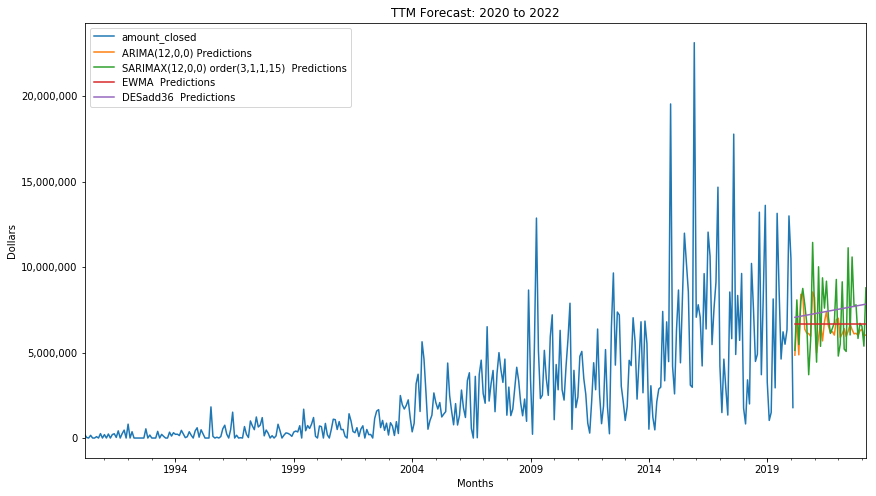

In [47]:
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# plot predictions against known values
title = 'TTM Forecast: 2020 to 2022'
ylabel = 'Dollars'
xlabel = 'Months'

ax = ppc['amount_closed'].plot(figsize = (14,8), title = title, legend = True)
frcst_arima.plot(legend = True)
frcst_sarimax.plot(legend = True)
frcst_ewma.plot(legend = True)
frcst_desadd36.plot(legend = True)
ax.autoscale(axis = 'x', tight = True)
ax.set(ylabel = ylabel, xlabel = xlabel)
ax.yaxis.set_major_formatter(formatter)
;

## Create files for End User

In [45]:
ppc_frcst['Predictions_Average'] = ppc_frcst.mean(axis = 1)
ppc_frcst.to_csv('ttm_forecast_2020_2022_by_month.csv')

# for column in ppc_frcst.columns:
#     ppc_frcst[column] = ['{:,.0f}'.format(i) for i in ppc_frcst[column]]
    
ppc_frcst

ARIMA(12,0,0) Predictions  \
2020-03-01               4.846581e+06   
2020-04-01               7.085974e+06   
2020-05-01               4.864943e+06   
2020-06-01               8.405712e+06   
2020-07-01               8.368261e+06   
2020-08-01               6.372404e+06   
2020-09-01               6.142631e+06   
2020-10-01               6.108521e+06   
2020-11-01               5.953107e+06   
2020-12-01               8.538583e+06   
2021-01-01               8.220542e+06   
2021-02-01               4.980784e+06   
2021-03-01               5.889010e+06   
2021-04-01               6.692791e+06   
2021-05-01               5.682138e+06   
2021-06-01               6.807585e+06   
2021-07-01               7.386653e+06   
2021-08-01               6.546111e+06   
2021-09-01               6.173729e+06   
2021-10-01               6.225053e+06   
2021-11-01               6.020306e+06   
2021-12-01               6.920426e+06   
2022-01-01               7.008080e+06   
2022-02-01               5.875240e+06   
2022-03-01               6.101360e+06   
2022-04-01               6.398254e+06   
2022-05-01               5.936365e+06   
2022-06-01               6.246345e+06   
2022-07-01               6.654019e+06   
2022-08-01               6.335300e+06   
2022-09-01               6.093075e+06   
2022-10-01               6.126000e+06   
2022-11-01               6.005572e+06   
2022-12-01               6.277264e+06   
2023-01-01               6.368579e+06   
2023-02-01               5.990672e+06   
2023-03-01               6.025719e+06   

            SARIMAX(12,0,0) order(3,1,1,15)  Predictions          EWMA  \
2020-03-01                                  5.129045e+06  6.686615e+06   
2020-04-01                                  8.078377e+06  6.686615e+06   
2020-05-01                                  5.469719e+06  6.686615e+06   
2020-06-01                                  7.986351e+06  6.686615e+06   
2020-07-01                                  8.749382e+06  6.686615e+06   
2020-08-01                                  7.826274e+06  6.686615e+06   
2020-09-01                                  6.757393e+06  6.686615e+06   
2020-10-01                                  3.703069e+06  6.686615e+06   
2020-11-01                                  5.756671e+06  6.686615e+06   
2020-12-01                                  1.143924e+07  6.686615e+06   
2021-01-01                                  7.273521e+06  6.686615e+06   
2021-02-01                                  4.439402e+06  6.686615e+06   
2021-03-01                                  1.001678e+07  6.686615e+06   
2021-04-01                                  5.363575e+06  6.686615e+06   
2021-05-01                                  9.369583e+06  6.686615e+06   
2021-06-01                                  7.597484e+06  6.686615e+06   
2021-07-01                                  9.173877e+06  6.686615e+06   
2021-08-01                                  7.071030e+06  6.686615e+06   
2021-09-01                                  6.118416e+06  6.686615e+06   
2021-10-01                                  6.413127e+06  6.686615e+06   
2021-11-01                                  6.743747e+06  6.686615e+06   
2021-12-01                                  9.274903e+06  6.686615e+06   
2022-01-01                                  4.794808e+06  6.686615e+06   
2022-02-01                                  5.497629e+06  6.686615e+06   
2022-03-01                                  9.135537e+06  6.686615e+06   
2022-04-01                                  5.204223e+06  6.686615e+06   
2022-05-01                                  5.065314e+06  6.686615e+06   
2022-06-01                                  1.112612e+07  6.686615e+06   
2022-07-01                                  6.029208e+06  6.686615e+06   
2022-08-01                                  1.058849e+07  6.686615e+06   
2022-09-01                                  7.691635e+06  6.686615e+06   
2022-10-01                                  7.790355e+06  6.686615e+06   
2022-11-01 

In [46]:
ppc_frcst_annual = ppc_frcst.resample('A').sum()
ppc_frcst_annual.to_csv('ttm_forecast_2020_2022_by_year.csv')
ppc_frcst_annual

ARIMA(12,0,0) Predictions  \
2020-12-31               6.668672e+07   
2021-12-31               7.754513e+07   
2022-12-31               7.505687e+07   
2023-12-31               1.838497e+07   

            SARIMAX(12,0,0) order(3,1,1,15)  Predictions          EWMA  \
2020-12-31                                  7.089552e+07  6.686615e+07   
2021-12-31                                  8.885545e+07  8.023938e+07   
2022-12-31                                  8.545359e+07  8.023938e+07   
2023-12-31                                  2.069735e+07  2.005985e+07   

                DESadd36  Predictions_Average  
2020-12-31  7.156180e+07         6.900255e+07  
2021-12-31  8.869917e+07         8.383478e+07  
2022-12-31  9.178100e+07         8.313271e+07  
2023-12-31  2.342678e+07         2.064224e+07